In [25]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

### Speech to text translation from Scratch to detect words: yes, no, up, down, left, right, on, off, stop, and go.
### Dataset taken from a Google Kaggle competition

In [26]:
import PIL

Switching to GPU

In [27]:
physical_device=tf.config.experimental.list_physical_devices('GPU')
print("No. of GPUs Available: ",len(physical_device))
tf.config.experimental.set_memory_growth(physical_device[0],True)

No. of GPUs Available:  1


##### Exploratory Data Analysis

Visualizing the data

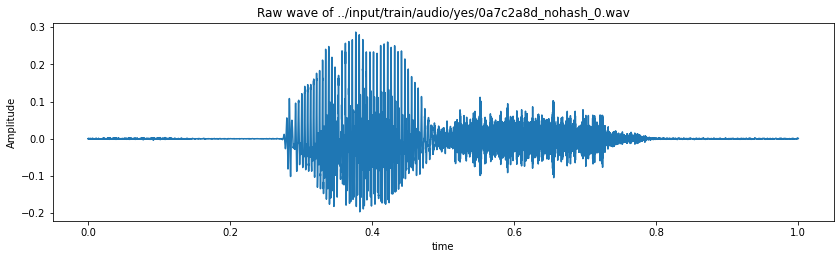

In [5]:
train_audio_path = 'train/train/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [6]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


##### Resampling the data to 8000 Hz

In [7]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

Finding out all the categories

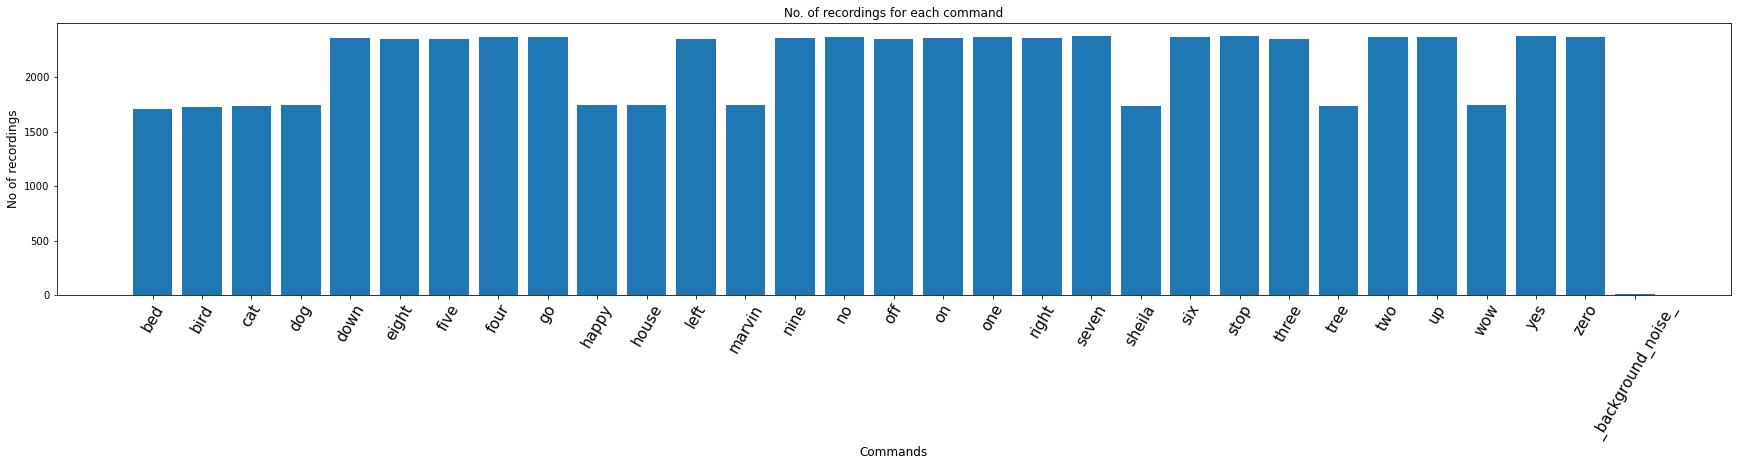

In [8]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


looking at the distribution of the duration of recordings

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

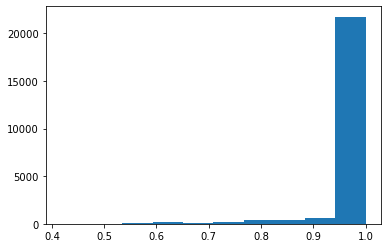

In [9]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))


###### Data Pre-processing

In [10]:
train_audio_path = 'train/train/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

###### One hot Encoding for Multi-Classification Problem

In [12]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [13]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

##### Splitting into train and validation set

In [14]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

### Model Architecture

In [28]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

### Model building

In [29]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [31]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 7s 13ms/step - loss: 2.1193 - accuracy: 0.1982 - val_loss: 1.8307 - val_accuracy: 0.3214
Epoch 2/100
533/533 [==============================] - 7s 13ms/step - loss: 1.5728 - accuracy: 0.3986 - val_loss: 1.3939 - val_accuracy: 0.5055
Epoch 3/100
533/533 [==============================] - 7s 13ms/step - loss: 1.1980 - accuracy: 0.5660 - val_loss: 0.9785 - val_accuracy: 0.6643
Epoch 4/100
533/533 [==============================] - 7s 13ms/step - loss: 0.9794 - accuracy: 0.6510 - val_loss: 0.8660 - val_accuracy: 0.6976
Epoch 5/100
533/533 [==============================] - 7s 13ms/step - loss: 0.8760 - accuracy: 0.6939 - val_loss: 0.7783 - val_accuracy: 0.7403
Epoch 6/100
533/533 [==============================] - 7s 13ms/step - loss: 0.7932 - accuracy: 0.7237 - val_loss: 0.7340 - val_accuracy: 0.7452
Epoch 7/100
533/533 [==============================] - 7s 13ms/step - loss: 0.7546 - accuracy: 0.7396 - val_loss: 0.6705 - val_accuracy:

Epoch 28/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3422 - accuracy: 0.8835 - val_loss: 0.4551 - val_accuracy: 0.8503
Epoch 29/100
533/533 [==============================] - 7s 14ms/step - loss: 0.3224 - accuracy: 0.8891 - val_loss: 0.4683 - val_accuracy: 0.8510
Epoch 30/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3238 - accuracy: 0.8884 - val_loss: 0.4771 - val_accuracy: 0.8452
Epoch 31/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3204 - accuracy: 0.8936 - val_loss: 0.4526 - val_accuracy: 0.8546
Epoch 32/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3138 - accuracy: 0.8924 - val_loss: 0.4662 - val_accuracy: 0.8499
Epoch 33/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3073 - accuracy: 0.8964 - val_loss: 0.4819 - val_accuracy: 0.8496
Epoch 34/100
533/533 [==============================] - 8s 14ms/step - loss: 0.3037 - accuracy: 0.8978 - val_loss: 0.4776 - val_ac

### Plot

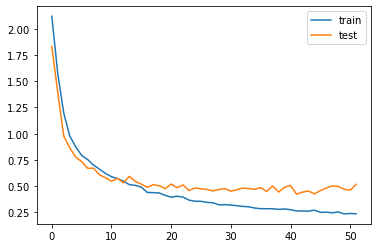

In [35]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

### Saving the model

In [37]:
model.save("best_model", save_format="hdf5")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model\assets


In [44]:
from keras.models import load_model
best_model=load_model('./best_model')

### Defining prediction

In [45]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Testung it on a random value

In [46]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: go
Text: go


# Live Test 
Using the code below I recorded an audio file for every category. You can find them in the input folder and even try recording yourself

In [127]:
# import sounddevice as sd
# import soundfile as sf

# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/yes.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [177]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/no.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [181]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/up.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [180]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/down.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

In [173]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/left.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [136]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/right.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [137]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/on.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [138]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/off.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [139]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/stop.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


In [140]:
# samplerate = 16000  
# duration = 1 # seconds
# filename = './input/voice_commands/simar_voice/go.wav'
# print("start")
# mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
#     channels=1, blocking=True)
# print("end")
# sd.wait()
# sf.write(filename, mydata, samplerate)

start
end


Making sure that the audio files have been stored

In [144]:
os.listdir('./input/voice_commands/simar_voice')

['down.wav',
 'go.wav',
 'left.wav',
 'no.wav',
 'off.wav',
 'on.wav',
 'right.wav',
 'stop.wav',
 'up.wav',
 'yes.wav']

In [145]:
filepath='./input/voice_commands/simar_voice'

Predicting Every Category Using our model

In [183]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath+'/down.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [184]:
predict(samples)

'down'

In [185]:
samples, sample_rate = librosa.load(filepath+'/go.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [186]:
predict(samples)

'go'

In [187]:
samples, sample_rate = librosa.load(filepath+'/left.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [188]:
predict(samples)

'left'

In [189]:
samples, sample_rate = librosa.load(filepath+'/no.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [190]:
predict(samples)

'no'

In [191]:
samples, sample_rate = librosa.load(filepath+'/off.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [192]:
predict(samples)

'off'

In [193]:
samples, sample_rate = librosa.load(filepath+'/on.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

In [194]:
predict(samples)

'on'

In [195]:
samples, sample_rate = librosa.load(filepath+'/right.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [196]:
predict(samples)

'right'

In [197]:
samples, sample_rate = librosa.load(filepath+'/stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [198]:
predict(samples)

'stop'

In [199]:
samples, sample_rate = librosa.load(filepath+'/up.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [200]:
predict(samples)

'up'

In [201]:
samples, sample_rate = librosa.load(filepath+'/yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

In [202]:
predict(samples)

'yes'

### The model was able to predict all the categories correctly